### Multi step model (simple encoder-decoder)

In this notebook, we demonstrate how to:
- prepare time series data for training a RNN forecasting model
- get data in the required shape for the keras API
- implement a RNN model in keras to predict the next 3 steps ahead (time *t+1* to *t+3*) in the time series. This model uses a simple encoder decoder approach in which the final hidden state of the encoder is replicated across each time step of the decoder. 
- enable early stopping to reduce the likelihood of model overfitting
- evaluate the model on a test dataset

The data in this example is taken from the GEFCom2014 forecasting competition<sup>1</sup>. It consists of 3 years of hourly electricity load and temperature values between 2012 and 2014. The task is to forecast future values of electricity load.

<sup>1</sup>Tao Hong, Pierre Pinson, Shu Fan, Hamidreza Zareipour, Alberto Troccoli and Rob J. Hyndman, "Probabilistic energy forecasting: Global Energy Forecasting Competition 2014 and beyond", International Journal of Forecasting, vol.32, no.3, pp 896-913, July-September, 2016.

In [9]:
import os
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
from collections import UserDict
from IPython.display import Image
%matplotlib inline

from common.utils import load_data, mape, TimeSeriesTensor, create_evaluation_df

pd.options.display.float_format = '{:,.20f}'.format
np.set_printoptions(precision=20)
warnings.filterwarnings("ignore")

In [10]:
var_name = 'Cuc'
sat_var = 2

In [68]:
Paras = {
     'M0':['M0'],
    'e':['OMEGA','i0','omega','I_dot','Cus','Crs','e' , 'M0'],
    'sqrt_A':['Cuc','Crc','Del_n','Crs','sqrt_A','OMEGA_dot','Cus'],
    'OMEGA':['OMEGA','e','i0','omega'],
    'i0':['e','i0','omega','OMEGA' ,'I_dot'],
    'omega':['omega','e','OMEGA','i0'],
    'I_dot':['I_dot','e','Crs','Cuc'],
    'Cic':['M0','Cic'],
    'Cis':['Cis'],
    'OMEGA_dot':['OMEGA_dot','sqrt_A','Crc','Del_n','Cus' , 'omega' ],
    'Cuc':['Cuc','e','sqrt_A','I_dot','Crs'],
    'Cus':['Cus','sqrt_A','OMEGA_dot','Crc','Del_n','Cus'],
    'Crc':['Crc','sqrt_A','OMEGA_dot','Cus','Del_n'],
    'Crs':['Crs','e','sqrt_A','I_dot','Cuc'],
    'Del_n':['Crc','sqrt_A','OMEGA_dot','Cus','Del_n'],
    'Codes' : ['Codes']    
}

In [69]:
df = pd.read_csv("hourinterpol_21.csv" , parse_dates = True)
a = pd.to_datetime(df['Epoch_Time_of_Clock'])
print(type(a[0]))
#df = df.drop(['Unnamed: 0', 'Unnamed: 0.1' ,'sqrt_A'  ,'PRN','SV_Clock_Bias', 'SV_Clock_Drift', 'SV_Clock_Drift_Rate', 'IODE', 'Crs',
#       'Del_n', 'Cuc','Cus','Toe', 'Cic', 
#       'Cis', 'Crc', 'M0', 'OMEGA_dot', 'I_dot', 'Codes', 'GPS_week',
#       'L2_P_Data_flag', 'SV_accuracy', 'SV_health', 'Tgd', 'IODC', 'T_Tx',
#       'Fit_Interval' ,'Epoch_Time_of_Clock' ],axis =1 )
df = df.loc[:,Paras[var_name]]
#df.head()
#df = df.set_index(['Epoch_Time_of_Clock'])
df = df.set_index(a)
df.head()

<class 'pandas._libs.tslib.Timestamp'>


,Cuc,e,sqrt_A,I_dot,Crs
Epoch_Time_of_Clock,,,,,
2017-11-02 00:00:00,0.00000217067884273000,0.01721513770000000082,"5,153.60276332000012189383",-0.00000000002843166174,36.35361028460000198947
2017-11-02 01:00:00,0.00000199300000000000,0.01721521969999999929,"5,153.60349115999997593462",0.00000000003741579694,34.63119122119999815368
2017-11-02 02:00:00,0.00000178620121187000,0.01721531310000000078,"5,153.60420780999993439764",0.00000000010932434064,32.61727921500000348942
2017-11-02 03:00:00,0.00000155187608717000,0.01721541749999999996,"5,153.60488581000026897527",0.00000000018632771238,30.34622309439999909841
2017-11-02 04:00:00,0.00000129661392782000,0.01721552709999999917,"5,153.60550435000004654285",0.00000000026668198989,27.90236791449999742554


In [70]:
test = df.iloc[265:408,:]

In [71]:

df.head(7)

,Cuc,e,sqrt_A,I_dot,Crs
Epoch_Time_of_Clock,,,,,
2017-11-02 00:00:00,0.00000217067884273000,0.01721513770000000082,"5,153.60276332000012189383",-0.00000000002843166174,36.35361028460000198947
2017-11-02 01:00:00,0.00000199300000000000,0.01721521969999999929,"5,153.60349115999997593462",0.00000000003741579694,34.63119122119999815368
2017-11-02 02:00:00,0.00000178620121187000,0.01721531310000000078,"5,153.60420780999993439764",0.00000000010932434064,32.61727921500000348942
2017-11-02 03:00:00,0.00000155187608717000,0.01721541749999999996,"5,153.60488581000026897527",0.00000000018632771238,30.34622309439999909841
2017-11-02 04:00:00,0.00000129661392782000,0.01721552709999999917,"5,153.60550435000004654285",0.00000000026668198989,27.90236791449999742554
2017-11-02 05:00:00,0.00000113946835580000,0.01721551229999999932,"5,153.60619630000019242289",0.00000000033075694795,26.51997194949999681057
2017-11-02 06:00:00,0.00000129871766113000,0.01721513740000000028,"5,153.60722543999963818351",0.00000000034334601486,28.44754875070000110782


# Enter number of entries per day

In [72]:
'''entry = 6
print(df.shape[0])
no_of_entries = df.shape[0]//entry
valid = (no_of_entries * 70)//100
test = (no_of_entries * 85)//100
indexes = df.index
#print(valid , test , indexes)
valid_start_dt = indexes[int(valid)*int(entry)] 
test_start_dt = indexes [int(test)*int(entry)] 
test_start_dt = str(test_start_dt)
valid_start_dt = str(valid_start_dt)
print(test_start_dt,valid_start_dt)
print(type(test_start_dt))'''
valid_start_dt = '2017-11-07 00:00:00'
test_start_dt = '2017-11-10 00:00:00'


Load data into Pandas dataframe

# enter lag and no. of outputs

In [73]:
"""total = len(df)
t = total*70/100
t = round(t)
indexes = df.index
valid_start_dt = str(indexes[t])
t = total*85/100
t = round(t)
test_start_dt = str(indexes[t])
print(valid_start_dt , test_start_dt)
"""
T = 24
HORIZON = 24

Create training set containing only the model features

In [74]:
train = df.copy()[df.index < valid_start_dt][Paras[var_name ]]
train.head()

,Cuc,e,sqrt_A,I_dot,Crs
Epoch_Time_of_Clock,,,,,
2017-11-02 00:00:00,0.00000217067884273000,0.01721513770000000082,"5,153.60276332000012189383",-0.00000000002843166174,36.35361028460000198947
2017-11-02 01:00:00,0.00000199300000000000,0.01721521969999999929,"5,153.60349115999997593462",0.00000000003741579694,34.63119122119999815368
2017-11-02 02:00:00,0.00000178620121187000,0.01721531310000000078,"5,153.60420780999993439764",0.00000000010932434064,32.61727921500000348942
2017-11-02 03:00:00,0.00000155187608717000,0.01721541749999999996,"5,153.60488581000026897527",0.00000000018632771238,30.34622309439999909841
2017-11-02 04:00:00,0.00000129661392782000,0.01721552709999999917,"5,153.60550435000004654285",0.00000000026668198989,27.90236791449999742554


In [75]:
train.tail(6)

,Cuc,e,sqrt_A,I_dot,Crs
Epoch_Time_of_Clock,,,,,
2017-11-06 18:00:00,-0.00000111480903523000,0.01721449809999999955,"5,153.63207126999986940064",0.00000000035667501811,-29.74364226139999800580
2017-11-06 19:00:00,-0.00000134974910027000,0.01721480480000000049,"5,153.63328971000009914860",0.00000000035979651108,-34.07791252970000073219
2017-11-06 20:00:00,-0.00000157119201363000,0.01721518340000000036,"5,153.63412335999964852817",0.00000000036735473078,-37.94787707700000112254
2017-11-06 21:00:00,-0.00000177614461259000,0.01721562880000000045,"5,153.63453819999995175749",0.00000000037910472133,-41.32643629889999914440
2017-11-06 22:00:00,-0.00000196161373439000,0.01721613569999999940,"5,153.63450018999992607860",0.00000000039480152686,-44.18649059079999830146
2017-11-06 23:00:00,-0.00000212460621630000,0.01721669899999999850,"5,153.63397531000009621494",0.00000000041420019150,-46.50094034829999856129


Scale data to be in range (0, 1). This transformation should be calibrated on the training set only. This is to prevent information from the validation or test sets leaking into the training data.

# Enter variable to be predicted

In [76]:
from sklearn.preprocessing import StandardScaler



y_scalar = StandardScaler()
y_scalar.fit(train[[var_name]])


X_scaler = StandardScaler()
train[Paras[var_name]] = X_scaler.fit_transform(train)

In [77]:
import pickle
file_x = open(var_name+'_X_scaler2_5D.pkl','wb')
pickle.dump(X_scaler, file_x)
            
file_y = open(var_name+'_y_scalar2_5D.pkl','wb')
pickle.dump(y_scalar, file_y)

Use the TimeSeriesTensor convenience class to:
1. Shift the values of the time series to create a Pandas dataframe containing all the data for a single training example
2. Discard any samples with missing values
3. Transform this Pandas dataframe into a numpy array of shape (samples, time steps, features) for input into Keras

The class takes the following parameters:

- **dataset**: original time series
- **H**: the forecast horizon
- **tensor_structure**: a dictionary discribing the tensor structure in the form { 'tensor_name' : (range(max_backward_shift, max_forward_shift), [feature, feature, ...] ) }
- **freq**: time series frequency
- **drop_incomplete**: (Boolean) whether to drop incomplete samples

In [78]:
tensor_structure = {'X':(range(-T+1, 1), Paras[var_name])}
train_inputs = TimeSeriesTensor(train, var_name, HORIZON, {'X':(range(-T+1, 1), Paras[var_name])} ,freq = None)

In [79]:
train_inputs.dataframe

tensor                               target                          \
feature                                   y                           
time step                               t+1                     t+2   
Epoch_Time_of_Clock                                                   
2017-11-02 23:00:00  0.78824889858991786795  0.68149166555178475324   
2017-11-03 00:00:00  0.68149166555178475324  0.56571957691636631793   
2017-11-03 01:00:00  0.56571957691636631793  0.44330294565158662179   
2017-11-03 02:00:00  0.44330294565158662179  0.31912724489306709685   
2017-11-03 03:00:00  0.31912724489306709685  0.25592663110654484404   
2017-11-03 04:00:00  0.25592663110654484404  0.36663923966838291024   
2017-11-03 05:00:00  0.36663923966838291024  0.59089016425143547906   
2017-11-03 06:00:00  0.59089016425143547906  0.70176675973606139625   
2017-11-03 07:00:00  0.70176675973606139625  0.67839232745422717308   
2017-11-03 08:00:00  0.67839232745422717308  0.70729191016115788848   
2017-11-03 09:00:00  0.70729191016115788848  0.83986609737673767473   
2017-11-03 10:00:00  0.83986609737673767473  0.98523905852362614333   
2017-11-03 11:00:00  0.98523905852362614333  1.09544146672577680235   
2017-11-03 12:00:00  1.09544146672577680235  1.17168940819548050847   
2017-11-03 13:00:00  1.17168940819548050847  1.21733746538887399602   
2017-11-03 14:00:00  1.21733746538887399602  1.23574022074183109687   
2017-11-03 15:00:00  1.23574022074183109687  1.23025225670373328235   
2017-11-03 16:00:00  1.23025225670373328235  1.20422815572396268990   
2017-11-03 17:00:00  1.20422815572396268990  1.16102250023839204118   
2017-11-03 18:00:00  1.16102250023839204118  1.10398987269640369568   
2017-11-03 19:00:00  1.10398987269640369568  1.03648485554062474989   
2017-11-03 20:00:00  1.03648485554062474989  0.96186203122043867353   
2017-11-03 21:00:00  0.96186203122043867353  0.88347598217171663393   
2017-11-03 22:00:00  0.88347598217171663393  0.80468129085059647565   
2017-11-03 23:00:00  0.80468129085059647565  0.72883253969970573927   
2017-11-04 00:00:00  0.72883253969970573927  0.65929459623577224558   
2017-11-04 01:00:00  0.65929459623577224558  0.59939118767912147323   
2017-11-04 02:00:00  0.59939118767912147323  0.55391411573298088289   
2017-11-04 03:00:00  0.55391411573298088289  0.55959425064258105920   
2017-11-04 04:00:00  0.55959425064258105920  0.67988040126763915616   
...                                     ...                     ...   
2017-11-04 18:00:00  0.44599645318333491772  0.34935435418381238781   
2017-11-04 19:00:00  0.34935435418381238781  0.25420481882764550674   
2017-11-04 20:00:00  0.25420481882764550674  0.16446255941848714199   
2017-11-04 21:00:00  0.16446255941848714199  0.08404228826674406405   
2017-11-04 22:00:00  0.08404228826674406405  0.01687897470913961653   
2017-11-04 23:00:00  0.01687897470913961653 -0.03317343998909057928   
2017-11-05 00:00:00 -0.03317343998909057928 -0.06215638566795392284   
2017-11-05 01:00:00 -0.06215638566795392284 -0.06612466745659861811   
2017-11-05 02:00:00 -0.06612466745659861811 -0.04075280210677873632   
2017-11-05 03:00:00 -0.04075280210677873632  0.02896708793747701169   
2017-11-05 04:00:00  0.02896708793747701169  0.16549247285410195740   
2017-11-05 05:00:00  0.16549247285410195740  0.31951009820433551312   
2017-11-05 06:00:00  0.31951009820433551312  0.37392891501985697777   
2017-11-05 07:00:00  0.37392891501985697777  0.31367124139691837659   
2017-11-05 08:00:00  0.31367124139691837659  0.22628890391340472643   
2017-11-05 09:00:00  0.22628890391340472643  0.14839009418221033032   
2017-11-05 10:00:00  0.14839009418221033032  0.06177061202941318274   
2017-11-05 11:00:00  0.06177061202941318274 -0.04242840565294182104   
2017-11-05 12:00:00 -0.04242840565294182104 -0.16121222091209688743   
2017-11-05 13:00:00 -0.16121222091209688743 -0.29107157099222075169   
2017-11-05 14:00:00 -0.29107157099222075169 -0.42849719313748185767   
2017-11-05 15:00:00 -0.4

In [80]:
train_inputs['target'].shape

(73, 24)

Construct validation set (keeping T hours from the training set in order to construct initial features)

In [81]:
look_back_dt = dt.datetime.strptime(valid_start_dt, '%Y-%m-%d %H:%M:%S') - dt.timedelta(hours=T-1)
valid = df.copy()[(df.index >=look_back_dt) & (df.index < test_start_dt)][Paras[var_name]]
valid[Paras[var_name]] = X_scaler.transform(valid)
valid_inputs = TimeSeriesTensor(valid, var_name, HORIZON, tensor_structure,freq = None)
valid_inputs.dataframe.head()

tensor                               target                          \
feature                                   y                           
time step                               t+1                     t+2   
Epoch_Time_of_Clock                                                   
2017-11-07 00:00:00 -2.99807589863437407018 -3.05049835479042252828   
2017-11-07 01:00:00 -3.05049835479042252828 -3.07964976720411742761   
2017-11-07 02:00:00 -3.07964976720411742761 -3.08265665134483457521   
2017-11-07 03:00:00 -3.08265665134483457521 -3.03705974574885928519   
2017-11-07 04:00:00 -3.03705974574885928519 -2.90243321489884920084   

tensor                                                               \
feature                                                               
time step                               t+3                     t+4   
Epoch_Time_of_Clock                                                   
2017-11-07 00:00:00 -3.07964976720411742761 -3.08265665134483457521   
2017-11-07 01:00:00 -3.08265665134483457521 -3.03705974574885928519   
2017-11-07 02:00:00 -3.03705974574885928519 -2.90243321489884920084   
2017-11-07 03:00:00 -2.90243321489884920084 -2.67474133326896179597   
2017-11-07 04:00:00 -2.67474133326896179597 -2.38962670723354442259   

tensor                                                               \
feature                                                               
time step                               t+5                     t+6   
Epoch_Time_of_Clock                                                   
2017-11-07 00:00:00 -3.03705974574885928519 -2.90243321489884920084   
2017-11-07 01:00:00 -2.90243321489884920084 -2.67474133326896179597   
2017-11-07 02:00:00 -2.67474133326896179597 -2.38962670723354442259   
2017-11-07 03:00:00 -2.38962670723354442259 -2.14039447218898892800   
2017-11-07 04:00:00 -2.14039447218898892800 -2.07046515832692268333   

tensor                                                               \
feature                                                               
time step                               t+7                     t+8   
Epoch_Time_of_Clock                                                   
2017-11-07 00:00:00 -2.67474133326896179597 -2.38962670723354442259   
2017-11-07 01:00:00 -2.38962670723354442259 -2.14039447218898892800   
2017-11-07 02:00:00 -2.14039447218898892800 -2.07046515832692268333   
2017-11-07 03:00:00 -2.07046515832692268333 -2.18903631141259058523   
2017-11-07 04:00:00 -2.18903631141259058523 -2.37153996566310132366   

tensor                                                               \
feature                                                               
time step                               t+9                    t+10   
Epoch_Time_of_Clock                                                   
2017-11-07 00:00:00 -2.14039447218898892800 -2.07046515832692268333   
2017-11-07 01:00:00 -2.07046515832692268333 -2.18903631141259058523   
2017-11-07 02:00:00 -2.18903631141259058523 -2.37153996566310132366   
2017-11-07 03:00:00 -2.37153996566310132366 -2.55128436029860594658   
2017-11-07 04:00:00 -2.55128436029860594658 -2.72545236626992570805   

tensor                        ...                                 X  \
feature                       ...                               Crs   
time step                     ...                               t-9   
Epoch_Time_of_Clock           ...                                     
2017-11-07 00:00:00           ...           -1.73899319583166511727   
2017-11-07 01:00:00           ...           -1.93547501690630308069   
2017-11-07 02:00:00           ...           -2.11843312871390754282   
2017-11-07 03:00:00           ...           -2.28691066294795586344   
2017-11-07 04:00:00           ...           -2.43995075129839600336   

tensor                                                               \
feature                                                               
time step         

## Implement the RNN

We will implement a RNN forecasting model with the following structure:

In [82]:
#Image('./images/simple_encoder_decoder.png')

In [86]:
from keras.models import Model, Sequential
from keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Flatten
from keras.callbacks import EarlyStopping ,ModelCheckpoint

In [87]:
LATENT_DIM = 64
BATCH_SIZE = 32
EPOCHS = 1000

In [95]:
model = Sequential()
model.add(LSTM(LATENT_DIM, input_shape=(T,5 )))
model.add(RepeatVector(HORIZON))
model.add(LSTM(LATENT_DIM, return_sequences=True))
model.add(TimeDistributed(Dense(1)))
model.add(Flatten())

In [96]:


model.compile(optimizer='RMSprop', loss='mse')

In [97]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 64)                17920     
_________________________________________________________________
repeat_vector_5 (RepeatVecto (None, 24, 64)            0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 24, 64)            33024     
_________________________________________________________________
time_distributed_5 (TimeDist (None, 24, 1)             65        
_________________________________________________________________
flatten_5 (Flatten)          (None, 24)                0         
Total params: 51,009
Trainable params: 51,009
Non-trainable params: 0
_________________________________________________________________


In [98]:
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=500)

In [99]:
best_val = ModelCheckpoint(str(sat_var) +'_' +  var_name + '_{epoch:02d}.h5', save_best_only=True, mode='min', period=1)

In [100]:
history = model.fit(train_inputs['X'],
          train_inputs['target'],
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          validation_data=(valid_inputs['X'], valid_inputs['target']),
          callbacks=[earlystop ,best_val],
          verbose=1 , shuffle = False)

Train on 73 samples, validate on 48 samples
Epoch 1/1000
73/73 [==============================] - 1s 19ms/step - loss: 0.6694 - val_loss: 22.5665
Epoch 2/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.2712 - val_loss: 21.3192
Epoch 3/1000
73/73 [==============================] - 0s 3ms/step - loss: 0.2102 - val_loss: 20.0429
Epoch 4/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.1655 - val_loss: 19.0731
Epoch 5/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.1491 - val_loss: 19.1307
Epoch 6/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.1468 - val_loss: 19.4132
Epoch 7/1000
73/73 [==============================] - 0s 3ms/step - loss: 0.1448 - val_loss: 19.0432
Epoch 8/1000
73/73 [==============================] - 0s 3ms/step - loss: 0.1398 - val_loss: 18.8570
Epoch 9/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.1416 - val_loss: 19.7370
Epoch 10/1000
73/73 [=========================

Epoch 81/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0590 - val_loss: 18.0614
Epoch 82/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0794 - val_loss: 16.6666
Epoch 83/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0573 - val_loss: 17.3706
Epoch 84/1000
73/73 [==============================] - 0s 3ms/step - loss: 0.0597 - val_loss: 17.6364
Epoch 85/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.0462 - val_loss: 16.8254
Epoch 86/1000
73/73 [==============================] - 0s 3ms/step - loss: 0.0574 - val_loss: 16.7513
Epoch 87/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.0722 - val_loss: 17.7744
Epoch 88/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0590 - val_loss: 16.8121
Epoch 89/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0513 - val_loss: 17.1023
Epoch 90/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0501 

73/73 [==============================] - 0s 3ms/step - loss: 0.0364 - val_loss: 15.9729
Epoch 161/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0307 - val_loss: 15.2369
Epoch 162/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0274 - val_loss: 15.4305
Epoch 163/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0197 - val_loss: 15.6303
Epoch 164/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0218 - val_loss: 15.6755
Epoch 165/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0233 - val_loss: 15.3622
Epoch 166/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0282 - val_loss: 15.3319
Epoch 167/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.0249 - val_loss: 15.7570
Epoch 168/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0256 - val_loss: 15.3208
Epoch 169/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0220 - val

73/73 [==============================] - 0s 1ms/step - loss: 0.0126 - val_loss: 13.9085
Epoch 240/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0131 - val_loss: 12.8650
Epoch 241/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0118 - val_loss: 14.0808
Epoch 242/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0227 - val_loss: 13.4756
Epoch 243/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0216 - val_loss: 13.6752
Epoch 244/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0165 - val_loss: 13.0212
Epoch 245/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0118 - val_loss: 13.7829
Epoch 246/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0144 - val_loss: 13.1931
Epoch 247/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0125 - val_loss: 13.4340
Epoch 248/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0124 - val

73/73 [==============================] - 0s 2ms/step - loss: 0.0125 - val_loss: 11.8118
Epoch 319/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0147 - val_loss: 12.2817
Epoch 320/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0101 - val_loss: 11.6267
Epoch 321/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0083 - val_loss: 12.4419
Epoch 322/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.0064 - val_loss: 11.4221
Epoch 323/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0115 - val_loss: 12.0367
Epoch 324/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0124 - val_loss: 11.7544
Epoch 325/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0196 - val_loss: 12.0300
Epoch 326/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0151 - val_loss: 11.5175
Epoch 327/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0094 - val

73/73 [==============================] - 0s 2ms/step - loss: 0.0090 - val_loss: 11.1586
Epoch 398/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0096 - val_loss: 10.5657
Epoch 399/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0111 - val_loss: 11.5961
Epoch 400/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0092 - val_loss: 10.7391
Epoch 401/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0070 - val_loss: 11.4481
Epoch 402/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0060 - val_loss: 10.5573
Epoch 403/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0069 - val_loss: 11.8157
Epoch 404/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0069 - val_loss: 10.4280
Epoch 405/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0147 - val_loss: 11.0559
Epoch 406/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0094 - val

73/73 [==============================] - 0s 967us/step - loss: 0.0074 - val_loss: 9.7549
Epoch 477/1000
73/73 [==============================] - 0s 967us/step - loss: 0.0065 - val_loss: 10.4431
Epoch 478/1000
73/73 [==============================] - 0s 935us/step - loss: 0.0057 - val_loss: 9.9946
Epoch 479/1000
73/73 [==============================] - 0s 995us/step - loss: 0.0069 - val_loss: 10.8650
Epoch 480/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.0048 - val_loss: 9.4681
Epoch 481/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.0057 - val_loss: 10.5984
Epoch 482/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.0112 - val_loss: 9.9855
Epoch 483/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.0118 - val_loss: 10.1961
Epoch 484/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.0088 - val_loss: 9.8579
Epoch 485/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.0073 - 

73/73 [==============================] - 0s 979us/step - loss: 0.0076 - val_loss: 10.2516
Epoch 556/1000
73/73 [==============================] - 0s 941us/step - loss: 0.0044 - val_loss: 9.6617
Epoch 557/1000
73/73 [==============================] - 0s 987us/step - loss: 0.0047 - val_loss: 10.0256
Epoch 558/1000
73/73 [==============================] - 0s 905us/step - loss: 0.0048 - val_loss: 9.5951
Epoch 559/1000
73/73 [==============================] - 0s 999us/step - loss: 0.0053 - val_loss: 10.3122
Epoch 560/1000
73/73 [==============================] - 0s 968us/step - loss: 0.0039 - val_loss: 9.1351
Epoch 561/1000
73/73 [==============================] - 0s 1000us/step - loss: 0.0044 - val_loss: 9.9933
Epoch 562/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0104 - val_loss: 9.5000
Epoch 563/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0142 - val_loss: 9.6546
Epoch 564/1000
73/73 [==============================] - 0s 947us/step - loss: 0

Epoch 635/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.0053 - val_loss: 9.2859
Epoch 636/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0050 - val_loss: 8.4415
Epoch 637/1000
73/73 [==============================] - 0s 3ms/step - loss: 0.0049 - val_loss: 9.6460
Epoch 638/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.0041 - val_loss: 8.6480
Epoch 639/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.0076 - val_loss: 8.9760
Epoch 640/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0078 - val_loss: 8.6576
Epoch 641/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.0070 - val_loss: 9.2246
Epoch 642/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0045 - val_loss: 8.3965
Epoch 643/1000
73/73 [==============================] - 0s 945us/step - loss: 0.0033 - val_loss: 9.2802
Epoch 644/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.00

73/73 [==============================] - 0s 3ms/step - loss: 0.0029 - val_loss: 8.1903
Epoch 715/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0080 - val_loss: 7.7782
Epoch 716/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.0133 - val_loss: 7.9403
Epoch 717/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.0090 - val_loss: 7.8168
Epoch 718/1000
73/73 [==============================] - 0s 974us/step - loss: 0.0060 - val_loss: 8.1730
Epoch 719/1000
73/73 [==============================] - 0s 923us/step - loss: 0.0038 - val_loss: 7.7188
Epoch 720/1000
73/73 [==============================] - 0s 949us/step - loss: 0.0038 - val_loss: 8.0865
Epoch 721/1000
73/73 [==============================] - 0s 922us/step - loss: 0.0037 - val_loss: 7.7133
Epoch 722/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.0043 - val_loss: 8.2325
Epoch 723/1000
73/73 [==============================] - 0s 2ms/step - loss: 0.0036 - val_

73/73 [==============================] - 0s 947us/step - loss: 0.0031 - val_loss: 8.0061
Epoch 794/1000
73/73 [==============================] - 0s 969us/step - loss: 0.0066 - val_loss: 7.6044
Epoch 795/1000
73/73 [==============================] - 0s 905us/step - loss: 0.0089 - val_loss: 7.7589
Epoch 796/1000
73/73 [==============================] - 0s 962us/step - loss: 0.0060 - val_loss: 7.6421
Epoch 797/1000
73/73 [==============================] - 0s 970us/step - loss: 0.0043 - val_loss: 8.0299
Epoch 798/1000
73/73 [==============================] - 0s 934us/step - loss: 0.0028 - val_loss: 7.2453
Epoch 799/1000
73/73 [==============================] - 0s 898us/step - loss: 0.0038 - val_loss: 8.1229
Epoch 800/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0055 - val_loss: 7.4374
Epoch 801/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0049 - val_loss: 7.9252
Epoch 802/1000
73/73 [==============================] - 0s 940us/step - loss: 0.004

73/73 [==============================] - 0s 1ms/step - loss: 0.0041 - val_loss: 6.9230
Epoch 873/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0036 - val_loss: 7.4800
Epoch 874/1000
73/73 [==============================] - 0s 916us/step - loss: 0.0035 - val_loss: 7.0139
Epoch 875/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0042 - val_loss: 7.4519
Epoch 876/1000
73/73 [==============================] - 0s 941us/step - loss: 0.0054 - val_loss: 7.3379
Epoch 877/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0064 - val_loss: 7.0771
Epoch 878/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0079 - val_loss: 7.3822
Epoch 879/1000
73/73 [==============================] - 0s 928us/step - loss: 0.0054 - val_loss: 7.2473
Epoch 880/1000
73/73 [==============================] - 0s 966us/step - loss: 0.0051 - val_loss: 7.1522
Epoch 881/1000
73/73 [==============================] - 0s 912us/step - loss: 0.0035 - va

73/73 [==============================] - 0s 960us/step - loss: 0.0026 - val_loss: 6.6436
Epoch 952/1000
73/73 [==============================] - 0s 948us/step - loss: 0.0036 - val_loss: 7.1204
Epoch 953/1000
73/73 [==============================] - 0s 980us/step - loss: 0.0040 - val_loss: 6.6025
Epoch 954/1000
73/73 [==============================] - 0s 993us/step - loss: 0.0037 - val_loss: 7.0849
Epoch 955/1000
73/73 [==============================] - 0s 912us/step - loss: 0.0030 - val_loss: 6.4457
Epoch 956/1000
73/73 [==============================] - 0s 915us/step - loss: 0.0029 - val_loss: 7.1094
Epoch 957/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0047 - val_loss: 6.6456
Epoch 958/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0064 - val_loss: 6.9714
Epoch 959/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0053 - val_loss: 6.6722
Epoch 960/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0035 - 

In [102]:
best_epoch = np.argmin(np.array(history.history['val_loss']))+1
model.load_weights(str(sat_var) +'_' +  var_name + '_{:02d}.h5'.format(best_epoch))

## Evaluate the model

In [103]:
#look_back_dt = dt.datetime.strptime(test_start_dt, '%Y-%m-%d %H:%M:%S') - dt.timedelta(hours=T-1)
#test = df.copy()[test_start_dt:][Paras[var_name]]
test[Paras[var_name]] = X_scaler.transform(test)
test_inputs = TimeSeriesTensor(test, var_name, HORIZON, tensor_structure,freq =None)
test_inputs.dataframe.head()

tensor                               target                          \
feature                                   y                           
time step                               t+1                     t+2   
Epoch_Time_of_Clock                                                   
2017-11-14 00:00:00 -1.35712036723110318626 -1.29987085786772516016   
2017-11-14 01:00:00 -1.29987085786772516016 -1.23527778420019873629   
2017-11-14 02:00:00 -1.23527778420019873629 -1.16360787857330927331   
2017-11-14 03:00:00 -1.16360787857330927331 -1.10702164865681940142   
2017-11-14 04:00:00 -1.10702164865681940142 -1.10638808673781041669   

tensor                                                               \
feature                                                               
time step                               t+3                     t+4   
Epoch_Time_of_Clock                                                   
2017-11-14 00:00:00 -1.23527778420019873629 -1.16360787857330927331   
2017-11-14 01:00:00 -1.16360787857330927331 -1.10702164865681940142   
2017-11-14 02:00:00 -1.10702164865681940142 -1.10638808673781041669   
2017-11-14 03:00:00 -1.10638808673781041669 -1.13000648508093615163   
2017-11-14 04:00:00 -1.13000648508093615163 -1.07740672598812903260   

tensor                                                               \
feature                                                               
time step                               t+5                     t+6   
Epoch_Time_of_Clock                                                   
2017-11-14 00:00:00 -1.10702164865681940142 -1.10638808673781041669   
2017-11-14 01:00:00 -1.10638808673781041669 -1.13000648508093615163   
2017-11-14 02:00:00 -1.13000648508093615163 -1.07740672598812903260   
2017-11-14 03:00:00 -1.07740672598812903260 -0.95423384767421681740   
2017-11-14 04:00:00 -0.95423384767421681740 -0.87183944983050865041   

tensor                                                               \
feature                                                               
time step                               t+7                     t+8   
Epoch_Time_of_Clock                                                   
2017-11-14 00:00:00 -1.13000648508093615163 -1.07740672598812903260   
2017-11-14 01:00:00 -1.07740672598812903260 -0.95423384767421681740   
2017-11-14 02:00:00 -0.95423384767421681740 -0.87183944983050865041   
2017-11-14 03:00:00 -0.87183944983050865041 -0.86340805002375176080   
2017-11-14 04:00:00 -0.86340805002375176080 -0.88030407433832069675   

tensor                                                               \
feature                                                               
time step                               t+9                    t+10   
Epoch_Time_of_Clock                                                   
2017-11-14 00:00:00 -0.95423384767421681740 -0.87183944983050865041   
2017-11-14 01:00:00 -0.87183944983050865041 -0.86340805002375176080   
2017-11-14 02:00:00 -0.86340805002375176080 -0.88030407433832069675   
2017-11-14 03:00:00 -0.88030407433832069675 -0.89557929495949251120   
2017-11-14 04:00:00 -0.89557929495949251120 -0.90757803746929943678   

tensor                        ...                                 X  \
feature                       ...                               Crs   
time step                     ...                               t-9   
Epoch_Time_of_Clock           ...                                     
2017-11-14 00:00:00           ...           -1.55787992524395790817   
2017-11-14 01:00:00           ...           -1.50996258841757224900   
2017-11-14 02:00:00           ...           -1.46141714244212783669   
2017-11-14 03:00:00           ...           -1.41213678480364701606   
2017-11-14 04:00:00           ...           -1.36201471299521426062   

tensor                                                               \
feature                                                               
time step         

In [104]:
test_inputs.dataframe.head(50)

tensor                               target                          \
feature                                   y                           
time step                               t+1                     t+2   
Epoch_Time_of_Clock                                                   
2017-11-14 00:00:00 -1.35712036723110318626 -1.29987085786772516016   
2017-11-14 01:00:00 -1.29987085786772516016 -1.23527778420019873629   
2017-11-14 02:00:00 -1.23527778420019873629 -1.16360787857330927331   
2017-11-14 03:00:00 -1.16360787857330927331 -1.10702164865681940142   
2017-11-14 04:00:00 -1.10702164865681940142 -1.10638808673781041669   
2017-11-14 05:00:00 -1.10638808673781041669 -1.13000648508093615163   
2017-11-14 06:00:00 -1.13000648508093615163 -1.07740672598812903260   
2017-11-14 07:00:00 -1.07740672598812903260 -0.95423384767421681740   
2017-11-14 08:00:00 -0.95423384767421681740 -0.87183944983050865041   
2017-11-14 09:00:00 -0.87183944983050865041 -0.86340805002375176080   
2017-11-14 10:00:00 -0.86340805002375176080 -0.88030407433832069675   
2017-11-14 11:00:00 -0.88030407433832069675 -0.89557929495949251120   
2017-11-14 12:00:00 -0.89557929495949251120 -0.90757803746929943678   
2017-11-14 13:00:00 -0.90757803746929943678 -0.91574430368488557441   
2017-11-14 14:00:00 -0.91574430368488557441 -0.91952209542204332848   
2017-11-14 15:00:00 -0.91952209542204332848 -0.91835541449724122920   
2017-11-14 16:00:00 -0.91835541449724122920 -0.91168826272694736268   
2017-11-14 17:00:00 -0.91168826272694736268 -0.89896464192763037016   
2017-11-14 18:00:00 -0.89896464192763037016 -0.87962855391575833774   
2017-11-14 19:00:00 -0.87962855391575833774 -0.85312400050712400290   
2017-11-14 20:00:00 -0.85312400050712400290 -0.81889498351887135552   
2017-11-14 21:00:00 -0.81889498351887135552 -0.77638550476746848172   
2017-11-14 22:00:00 -0.77638550476746848172 -0.72503956606870845203   
2017-11-14 23:00:00 -0.72503956606870845203 -0.66430116923973481224   
2017-11-15 00:00:00 -0.66430116923973481224 -0.59361431609363823902   
2017-11-15 01:00:00 -0.59361431609363823902 -0.51242300845161603551   
2017-11-15 02:00:00 -0.51242300845161603551 -0.42113872996806772653   
2017-11-15 03:00:00 -0.42113872996806772653 -0.34242504660157174756   
2017-11-15 04:00:00 -0.34242504660157174756 -0.31817691201768488751   
2017-11-15 05:00:00 -0.31817691201768488751 -0.32176152945716030018   
2017-11-15 06:00:00 -0.32176152945716030018 -0.26167190541771867540   
2017-11-15 07:00:00 -0.26167190541771867540 -0.14949656604151095873   
2017-11-15 08:00:00 -0.14949656604151095873 -0.09899182326168780299   
2017-11-15 09:00:00 -0.09899182326168780299 -0.13761561750991341269   
2017-11-15 10:00:00 -0.13761561750991341269 -0.20333920890566831163   
2017-11-15 11:00:00 -0.20333920890566831163 -0.26232108135919340874   
2017-11-15 12:00:00 -0.26232108135919340874 -0.31309992689526061627   
2017-11-15 13:00:00 -0.31309992689526061627 -0.35551989391013572028   
2017-11-15 14:00:00 -0.35551989391013572028 -0.38944915846834055051   
2017-11-15 15:00:00 -0.38944915846834055051 -0.41477568581191004427   
2017-11-15 16:00:00 -0.41477568581191004427 -0.43130828442554025592   
2017-11-15 17:00:00 -0.43130828442554025592 -0.43897449796033410907   
2017-11-15 18:00:00 -0.43897449796033410907 -0.43762271327627944029   
2017-11-15 19:00:00 -0.43762271327627944029 -0.42712110643114309383   
2017-11-15 20:00:00 -0.42712110643114309383 -0.40734501090466196382   
2017-11-15 21:00:00 -0.40734501090466196382 -0.37814113052922304625   
2017-11-15 22:00:00 -0.37814113052922304625 -0.33939911358121738205   
2017-11-15 23:00:00 -0.33939911358121738205 -0.29097997873021752557   
2017-11-16 00:00:00 -0.29097997873021752557 -0.23275190202723469723   
2017-11-16 01:00:00 -0.23275190202723469723 -0.16458305953679119860   

tensor                                                               \
feature                                                               
time step              

In [105]:
test_inputs.dataframe.shape

(96, 144)

In [106]:
predictions = model.predict(test_inputs['X'])

In [107]:
predictions

array([[0.7689631 , 0.95200795, 0.9678241 , ..., 0.9829712 , 0.9817493 ,
        0.98069954],
       [0.79472184, 0.98465395, 1.0017401 , ..., 1.0107918 , 1.0096313 ,
        1.0086128 ],
       [0.8216125 , 1.0190274 , 1.0385513 , ..., 1.0586337 , 1.0579515 ,
        1.0573556 ],
       ...,
       [1.091838  , 1.2831633 , 1.3287721 , ..., 1.4268978 , 1.4246526 ,
        1.4231255 ],
       [1.0829313 , 1.2729399 , 1.3164139 , ..., 1.4089069 , 1.4068496 ,
        1.4054217 ],
       [1.0763534 , 1.2652899 , 1.3070247 , ..., 1.3953364 , 1.3934178 ,
        1.3920668 ]], dtype=float32)

In [108]:
eval_df = create_evaluation_df(predictions, test_inputs, HORIZON, y_scalar)
print(eval_df.head())
print(eval_df.tail())
print(eval_df.shape)


            timestamp    h             prediction                 actual
0 2017-11-14 00:00:00  t+1 0.00000320534777328447 0.00000005800000000000
1 2017-11-14 01:00:00  t+1 0.00000324347973029837 0.00000014274931427600
2 2017-11-14 02:00:00  t+1 0.00000328328728399798 0.00000023836967436600
3 2017-11-14 03:00:00  t+1 0.00000332475772843686 0.00000034446622302900
4 2017-11-14 04:00:00  t+1 0.00000336617734909001 0.00000042823365154000
               timestamp     h             prediction                 actual
2299 2017-11-17 19:00:00  t+24 0.00000423963334235995 0.00000093380535488000
2300 2017-11-17 20:00:00  t+24 0.00000420521893350624 0.00000083506056400800
2301 2017-11-17 21:00:00  t+24 0.00000417373712767760 0.00000074222545558800
2302 2017-11-17 22:00:00  t+24 0.00000414752934844707 0.00000065506129652500
2303 2017-11-17 23:00:00  t+24 0.00000412775942521349 0.00000057332935372700
(2304, 4)


In [109]:
eval_df['APE'] = (eval_df['prediction'] - eval_df['actual']).abs() / eval_df['actual']
eval_df.groupby('h')['APE'].mean()

h
t+1    2.75273381819391493863
t+10   1.94578224307341862698
t+11   1.91174840613080476714
t+12   1.87798266841201466626
t+13   1.84322773348438739838
t+14   1.80780278300358143717
t+15   1.77243331280856319943
t+16   1.73822391564816292053
t+17   1.70655172650645181598
t+18   1.67892797726635856215
t+19   1.65689474743035969340
t+2    2.49629633044838383782
t+20   1.64197414407643926815
t+21   1.63567874563351911554
t+22   1.63959214091474181352
t+23   1.65542831818174307479
t+24   1.68506017130148078031
t+3    2.32491681574477304650
t+4    2.23012037306887789256
t+5    2.17874723334693776167
t+6    2.14202621092446454654
t+7    2.09819722406651099078
t+8    2.03886205831756495144
t+9    1.98527421419640681677
Name: APE, dtype: float64

In [110]:
mape(eval_df['prediction'], eval_df['actual'])
from sklearn.metrics import mean_absolute_error
a = mean_absolute_error(eval_df['prediction'], eval_df['actual'])
a

2.513672681186101e-06

Plot actuals vs predictions at each horizon for first week of the test period. As is to be expected, predictions for one step ahead (*t+1*) are more accurate than those for 2 or 3 steps ahead

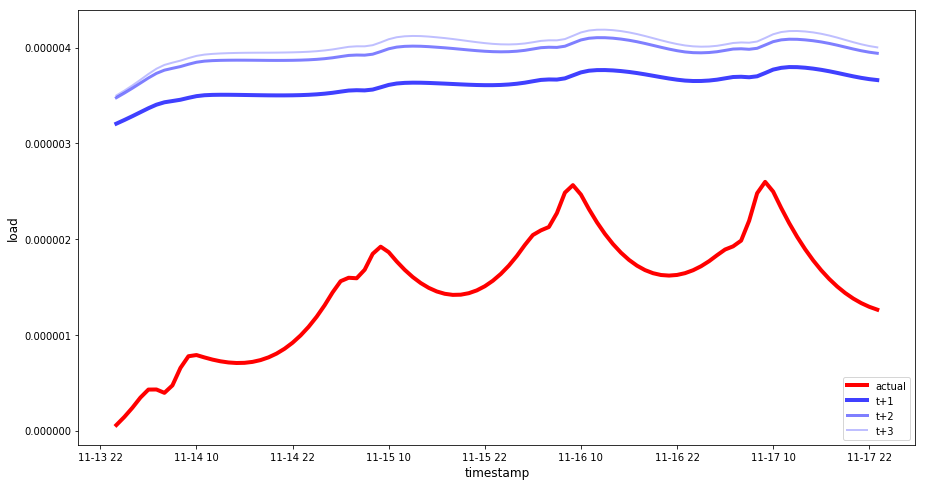

In [111]:
plot_df = eval_df[(eval_df.h=='t+1')][['timestamp', 'actual']]
for t in range(1, HORIZON+1):
    plot_df['t+'+str(t)] = eval_df[ (eval_df.h=='t+'+str(t))]['prediction'].values

fig = plt.figure(figsize=(15, 8))
ax = plt.plot(plot_df['timestamp'], plot_df['actual'], color='red', linewidth=4.0)
ax = fig.add_subplot(111)
ax.plot(plot_df['timestamp'], plot_df['t+1'], color='blue', linewidth=4.0, alpha=0.75)
ax.plot(plot_df['timestamp'], plot_df['t+2'], color='blue', linewidth=3.0, alpha=0.5)
ax.plot(plot_df['timestamp'], plot_df['t+3'], color='blue', linewidth=2.0, alpha=0.25)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
ax.legend(loc='best')
plt.show()

# take input here

In [140]:
a = df.iloc[456:480  , :]
Actual = df.iloc[480:504,:]

In [141]:
new_df = pd.DataFrame()

In [142]:
columns = Paras[var_name] 

In [143]:
for key , value in enumerate(columns):
    new_df[value] = a[value]

In [144]:
new_df = new_df.dropna( how = 'any')

In [145]:
new_df

,Cuc,e,sqrt_A,I_dot,Crs
Epoch_Time_of_Clock,,,,,
2017-11-21 00:00:00,-0.00000171164713137000,0.01731012380000000045,"5,153.63462513000013132114",0.00000000064354449566,-25.22663142380000067533
2017-11-21 01:00:00,-0.00000182731622923000,0.01731043319999999927,"5,153.63415566999992734054",0.00000000060365136709,-28.41827902140000006170
2017-11-21 02:00:00,-0.00000193640308747000,0.01731079439999999928,"5,153.63344813999992766185",0.00000000055520555667,-31.84350056099999903836
2017-11-21 03:00:00,-0.00000203735719018000,0.01731121350000000211,"5,153.63248875000044790795",0.00000000049818303618,-35.49633763730000168835
2017-11-21 04:00:00,-0.00000212910151124000,0.01731169379999999980,"5,153.63127672999962669564",0.00000000043370261769,-39.35827096570000094289
2017-11-21 05:00:00,-0.00000222144928961000,0.01731216650000000010,"5,153.63010962000043946318",0.00000000038916843881,-43.12188104129999999259
2017-11-21 06:00:00,-0.00000233124791809000,0.01731249659999999774,"5,153.62954738000007637311",0.00000000041432597238,-46.16784162479999764628
2017-11-21 07:00:00,-0.00000238712771946000,0.01731267419999999932,"5,153.62933602999964932678",0.00000000046935175398,-47.33511578249999729451
2017-11-21 08:00:00,-0.00000223786206242000,0.01731281620000000090,"5,153.62844985999981872737",0.00000000042976255544,-45.04067503520000315120


In [146]:
# creating index for output
import datetime
date = new_df.index.date[0]
date + datetime.timedelta(1)

datetime.date(2017, 11, 22)

In [147]:
import datetime
date = new_df.index + datetime.timedelta(days =1)

In [148]:
date

DatetimeIndex(['2017-11-22 00:00:00', '2017-11-22 01:00:00',
               '2017-11-22 02:00:00', '2017-11-22 03:00:00',
               '2017-11-22 04:00:00', '2017-11-22 05:00:00',
               '2017-11-22 06:00:00', '2017-11-22 07:00:00',
               '2017-11-22 08:00:00', '2017-11-22 09:00:00',
               '2017-11-22 10:00:00', '2017-11-22 11:00:00',
               '2017-11-22 12:00:00', '2017-11-22 13:00:00',
               '2017-11-22 14:00:00', '2017-11-22 15:00:00',
               '2017-11-22 16:00:00', '2017-11-22 17:00:00',
               '2017-11-22 18:00:00', '2017-11-22 19:00:00',
               '2017-11-22 20:00:00', '2017-11-22 21:00:00',
               '2017-11-22 22:00:00', '2017-11-22 23:00:00'],
              dtype='datetime64[ns]', name='Epoch_Time_of_Clock', freq='H')

In [149]:
new_df.index= date

In [150]:
new_df.columns

Index(['Cuc', 'e', 'sqrt_A', 'I_dot', 'Crs'], dtype='object')

In [151]:
print(new_df)
print(new_df.columns)

                                        Cuc                      e  \
Epoch_Time_of_Clock                                                  
2017-11-22 00:00:00 -0.00000171164713137000 0.01731012380000000045   
2017-11-22 01:00:00 -0.00000182731622923000 0.01731043319999999927   
2017-11-22 02:00:00 -0.00000193640308747000 0.01731079439999999928   
2017-11-22 03:00:00 -0.00000203735719018000 0.01731121350000000211   
2017-11-22 04:00:00 -0.00000212910151124000 0.01731169379999999980   
2017-11-22 05:00:00 -0.00000222144928961000 0.01731216650000000010   
2017-11-22 06:00:00 -0.00000233124791809000 0.01731249659999999774   
2017-11-22 07:00:00 -0.00000238712771946000 0.01731267419999999932   
2017-11-22 08:00:00 -0.00000223786206242000 0.01731281620000000090   
2017-11-22 09:00:00 -0.00000193154113496000 0.01731299979999999933   
2017-11-22 10:00:00 -0.00000171190219667000 0.01731325460000000122   
2017-11-22 11:00:00 -0.00000165842135703000 0.01731356170000000055   
2017-11-22 12:00:00 

In [152]:
freq = None
idx_tuples = []
drop_incomplete  = True
new_df[Paras[var_name]] = X_scaler.transform(new_df)
new_new_df = new_df.copy()
tensor_structure={'X':(range(-T+1, 1), Paras[var_name])}
for name, structure in tensor_structure.items():
        rng = structure[0]
        dataset_cols = structure[1]
        for col in dataset_cols:
        # do not shift non-sequential 'static' features
            if rng is None:
                new_df['context_'+col] = new_df[col]
                idx_tuples.append((name, col, 'static'))
            else:
                for t in rng:
                    sign = '+' if t > 0 else ''
                    shift = str(t) if t != 0 else ''
                    period = 't'+sign+shift
                    shifted_col = name+'_'+col+'_'+ period
                    new_new_df[shifted_col] = new_new_df[col].shift(t*-1, freq=freq)
                    idx_tuples.append((name, col, period))
        new_new_df = new_new_df.drop(new_df.columns, axis=1)
        idx = pd.MultiIndex.from_tuples(idx_tuples, names=['tensor', 'feature', 'time step'])
        print(new_df.head())
        new_new_df.columns = idx
        if drop_incomplete:
            new_new_df = new_new_df.dropna(how='any')
            
inputs = {}           
for name, structure in tensor_structure.items():
    rng = structure[0]
    cols = structure[1]
    tensor = new_new_df[name][cols].as_matrix()
    if rng is None:
        tensor = tensor.reshape(tensor.shape[0], len(cols))
    else:
        tensor = tensor.reshape(tensor.shape[0], len(cols), len(rng))
        tensor = np.transpose(tensor, axes=[0, 2, 1])
    inputs[name] = tensor

                                        Cuc                       e  \
Epoch_Time_of_Clock                                                   
2017-11-22 00:00:00 -2.55254514302698254369 51.55451347970707587365   
2017-11-22 01:00:00 -2.63068145784628493189 51.71782206826598127236   
2017-11-22 02:00:00 -2.70437136514033049650 51.90847191373366342759   
2017-11-22 03:00:00 -2.77256746675768983579 52.12968273941485364276   
2017-11-22 04:00:00 -2.83454221442887677185 52.38319636283037539215   

                                    sqrt_A                  I_dot  \
Epoch_Time_of_Clock                                                 
2017-11-22 00:00:00 2.63182082068376077544 1.13953408651561183262   
2017-11-22 01:00:00 2.57711243393486499897 0.93858654073287750563   
2017-11-22 02:00:00 2.49466062790323217513 0.69455788071238844239   
2017-11-22 03:00:00 2.38285838892279544510 0.40732707290303304948   
2017-11-22 04:00:00 2.24161598504703762913 0.08252973784132321133   

                  

In [153]:
print(new_new_df)
print(inputs['X'])

tensor                                    X                          \
feature                                 Cuc                           
time step                              t-23                    t-22   
Epoch_Time_of_Clock                                                   
2017-11-22 23:00:00 -2.55254514302698254369 -2.63068145784628493189   

tensor                                                               \
feature                                                               
time step                              t-21                    t-20   
Epoch_Time_of_Clock                                                   
2017-11-22 23:00:00 -2.70437136514033049650 -2.77256746675768983579   

tensor                                                               \
feature                                                               
time step                              t-19                    t-18   
Epoch_Time_of_Clock                                                   
2017

In [154]:
predictions = model.predict(inputs['X'])

In [155]:
predictions

array([[1.1180089, 1.30343  , 1.3381577, 1.3588163, 1.3751857, 1.3900814,
        1.405118 , 1.4197314, 1.432515 , 1.4422324, 1.4481822, 1.4501997,
        1.4486355, 1.4443065, 1.4382987, 1.4316843, 1.4252944, 1.4196327,
        1.4149146, 1.4111586, 1.4082748, 1.4061284, 1.404578 , 1.4034934]],
      dtype=float32)

In [156]:
print(predictions.shape)


(1, 24)


In [157]:
results = predictions[-1, :]

In [158]:
results

array([1.1180089, 1.30343  , 1.3381577, 1.3588163, 1.3751857, 1.3900814,
       1.405118 , 1.4197314, 1.432515 , 1.4422324, 1.4481822, 1.4501997,
       1.4486355, 1.4443065, 1.4382987, 1.4316843, 1.4252944, 1.4196327,
       1.4149146, 1.4111586, 1.4082748, 1.4061284, 1.404578 , 1.4034934],
      dtype=float32)

In [159]:
res_df = pd.DataFrame(results , columns = [var_name])
res_df

,Cuc
0,1.11800885200500488281
1,1.30342996120452880859
2,1.33815765380859375000
3,1.35881626605987548828
4,1.37518572807312011719
5,1.39008140563964843750
6,1.40511798858642578125
7,1.41973137855529785156
8,1.43251502513885498047
9,1.44223237037658691406


In [160]:
res_df.index = date
res_df

,Cuc
Epoch_Time_of_Clock,
2017-11-22 00:00:00,1.11800885200500488281
2017-11-22 01:00:00,1.30342996120452880859
2017-11-22 02:00:00,1.33815765380859375000
2017-11-22 03:00:00,1.35881626605987548828
2017-11-22 04:00:00,1.37518572807312011719
2017-11-22 05:00:00,1.39008140563964843750
2017-11-22 06:00:00,1.40511798858642578125
2017-11-22 07:00:00,1.41973137855529785156
2017-11-22 08:00:00,1.43251502513885498047


In [161]:
res_df[var_name] = y_scalar.inverse_transform(res_df[[var_name]])    

# final generated output 

In [162]:
# final generated ouput
#res_df['actual'] = Actual
res_df['actual'] = Actual
res_df

ValueError: Wrong number of items passed 5, placement implies 1

In [166]:
res_df.to_csv('SA2_Cuc.csv')